In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import tensorflow as tf
import numpy as np
import gpflow

from rtgp.rtgp import RTGPR
from rtgp.w import Shrinkage, Gaussian

import matplotlib.pyplot as plt
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
plt.rcParams['figure.figsize'] = (12, 5)

(0.0, 20.0)

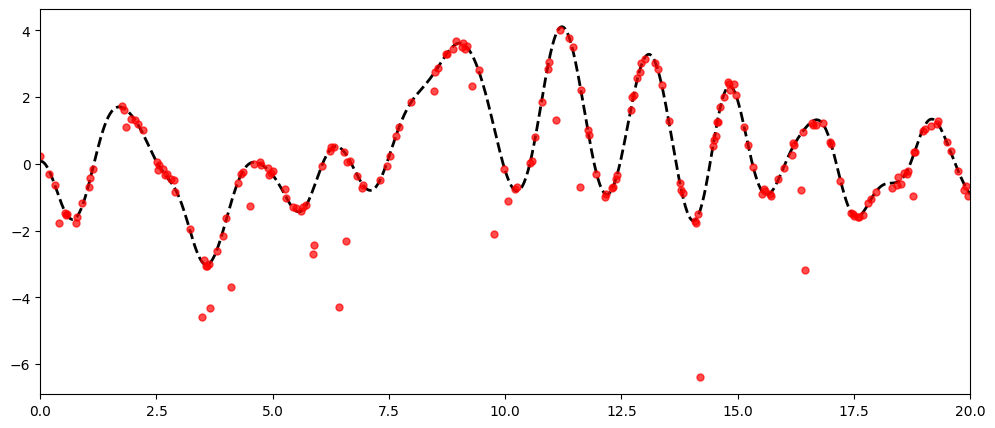

In [3]:
seed = 10

np.random.seed(seed)
tf.random.set_seed(seed)

n_points = 1000
sigma_n = 0.1
percent = 0.2
percent_miss = 0.1

lengthscale = 0.5
variance = 3

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int(percent * n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=len(i_obs)).reshape(len(i_obs), 1)
x_obs = x[i_obs]
n_obs = len(y_obs)

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_obs, 1), int(percent_miss * n_obs), replace=False)

y_obs[i_mis] = y_obs[i_mis] - np.abs(np.random.normal(scale=2, size=len(i_mis))).reshape(len(i_mis),1)

plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

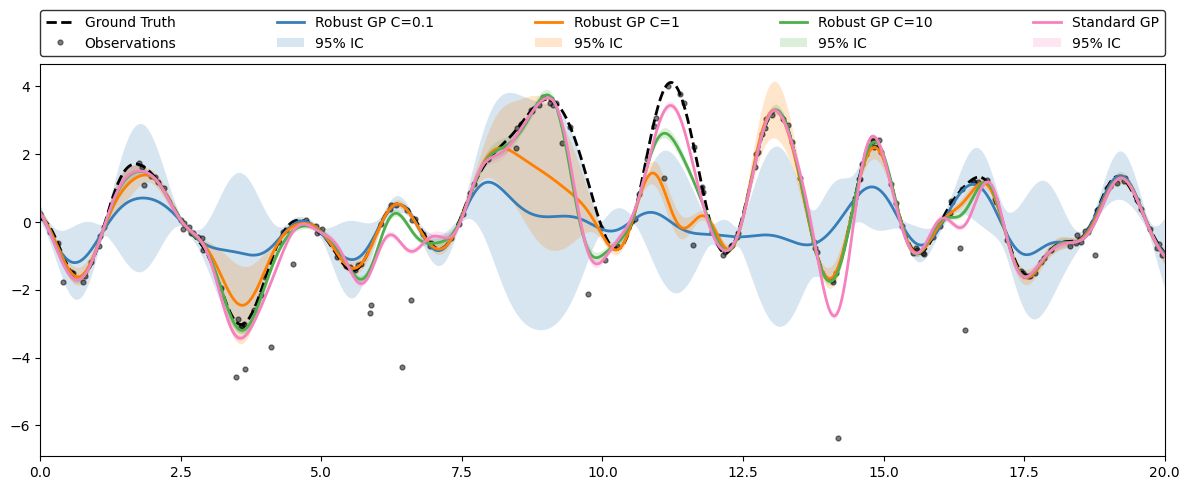

In [10]:
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])

for i, c in enumerate([0.1, 1, 10]):
    dsm_gp = RTGPR(
        (x_obs, y_obs),
        kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
        diffusion_matrix = Gaussian(C=c),
        noise_variance=sigma_n**2 
    )

    f_mean_dsm, f_var_dsm = dsm_gp.predict_f(x, full_cov=False)

    f_std_dsm = np.sqrt(f_var_dsm)
    plt.plot(x[:,0], f_mean_dsm, c=CB_color_cycle[i], lw=2, label= 'Robust GP C={}'.format(c))
    plt.fill_between(
        x[:,0],
        f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
        f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
        facecolor= CB_color_cycle[i],
        alpha=0.2,
        label='95% IC')
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    noise_variance=sigma_n**2
)

f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)
plt.plot(x[:,0], f_mean, c=CB_color_cycle[3], lw=2, label= 'Standard GP')
plt.fill_between(
    x[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[3],
    alpha=0.2,
    label='95% IC')

plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
            mode="expand", borderaxespad=0, ncol=5, edgecolor='k')
plt.tight_layout()



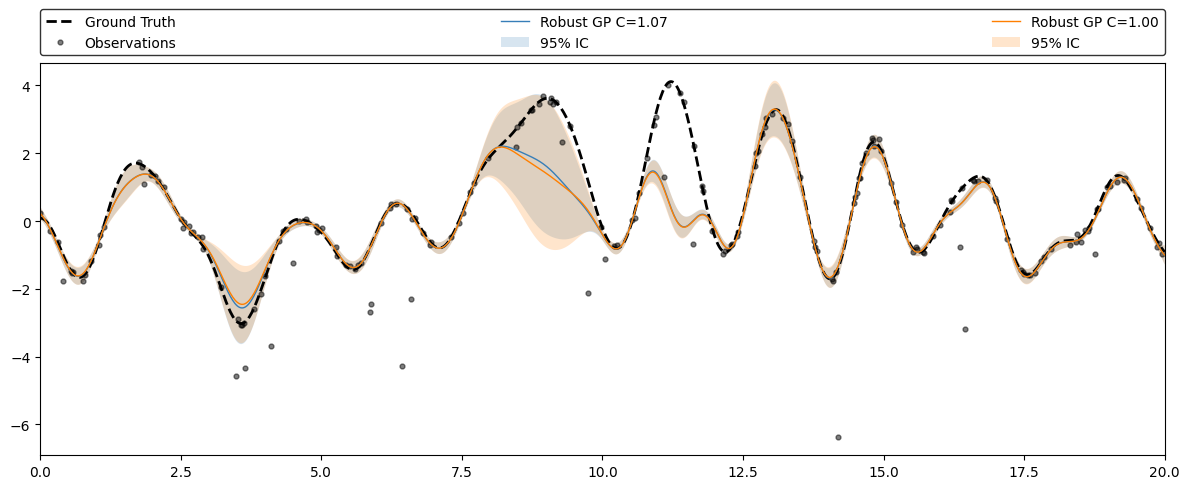

In [11]:
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])


mad = np.median(abs(y_obs-np.median(y_obs)))

for i, c in enumerate([mad, 1]):
    dsm_gp = RTGPR(
        (x_obs, y_obs),
        kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
        diffusion_matrix = Gaussian(C=c),
        noise_variance=sigma_n**2 
    )

    f_mean_dsm, f_var_dsm = dsm_gp.predict_f(x, full_cov=False)

    f_std_dsm = np.sqrt(f_var_dsm)
    plt.plot(x[:,0], f_mean_dsm, c=CB_color_cycle[i], lw=1, label= 'Robust GP C={:.2f}'.format(c))
    plt.fill_between(
        x[:,0],
        f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
        f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
        facecolor= CB_color_cycle[i],
        alpha=0.2,
        label='95% IC')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, edgecolor='k')
    plt.tight_layout()

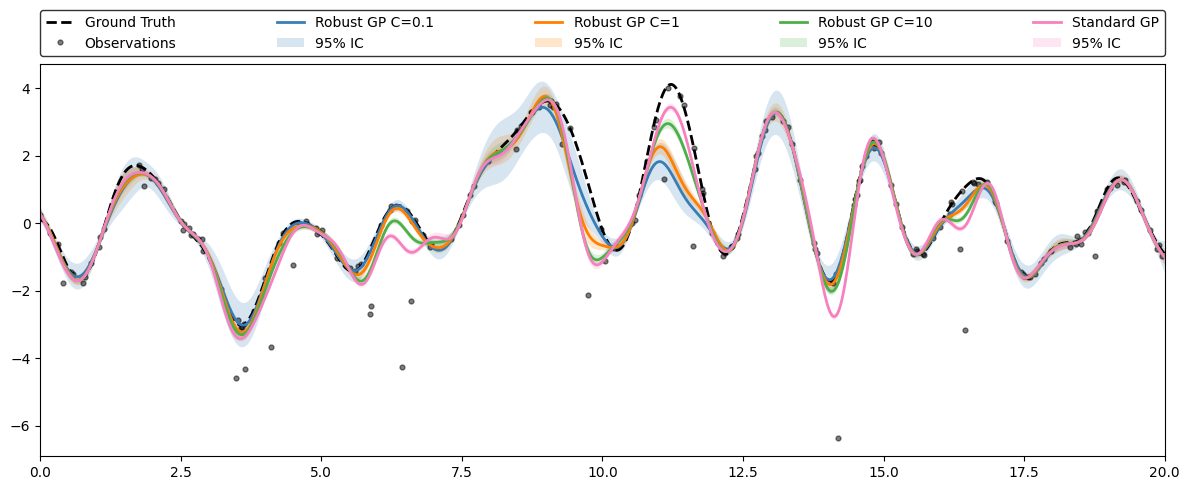

In [12]:
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])

for i, c in enumerate([0.1, 1, 10]):
    dsm_gp = RTGPR(
        (x_obs, y_obs),
        kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
        diffusion_matrix = Shrinkage(C=c),
        noise_variance=sigma_n**2 
    )

    f_mean_dsm, f_var_dsm = dsm_gp.predict_f(x, full_cov=False)

    f_std_dsm = np.sqrt(f_var_dsm)
    plt.plot(x[:,0], f_mean_dsm, c=CB_color_cycle[i], lw=2, label= 'Robust GP C={}'.format(c))
    plt.fill_between(
        x[:,0],
        f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
        f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
        facecolor= CB_color_cycle[i],
        alpha=0.2,
        label='95% IC')

    
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    noise_variance=sigma_n**2
)

f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)
plt.plot(x[:,0], f_mean, c=CB_color_cycle[3], lw=2, label= 'Standard GP')
plt.fill_between(
    x[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[3],
    alpha=0.2,
    label='95% IC')

plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
            mode="expand", borderaxespad=0, ncol=5, edgecolor='k')
plt.tight_layout()

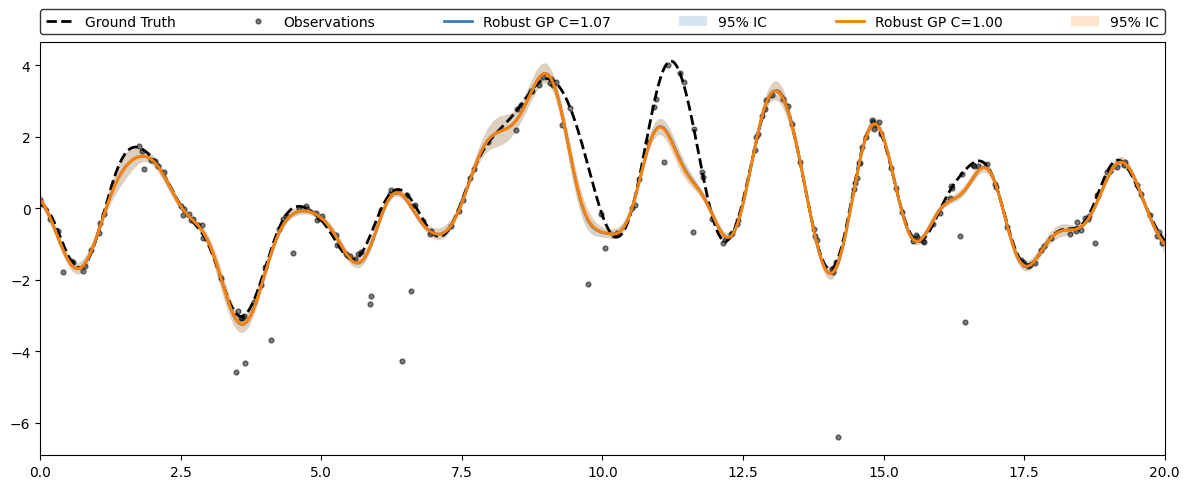

In [13]:
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])

for i, c in enumerate([mad, 1]):
    dsm_gp = RTGPR(
        (x_obs, y_obs),
        kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
        diffusion_matrix = Shrinkage(C=c),
        noise_variance=sigma_n**2 
    )

    f_mean_dsm, f_var_dsm = dsm_gp.predict_f(x, full_cov=False)

    f_std_dsm = np.sqrt(f_var_dsm)
    plt.plot(x[:,0], f_mean_dsm, c=CB_color_cycle[i], lw=2, label= 'Robust GP C={:.2f}'.format(c))
    plt.fill_between(
        x[:,0],
        f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
        f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
        facecolor= CB_color_cycle[i],
        alpha=0.2,
        label='95% IC')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=6, edgecolor='k')
    plt.tight_layout()